In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sns.set(style="whitegrid")

In [27]:
data = pd.read_csv('coronarias_drop (1).csv', sep=';')
df = pd.DataFrame(data, columns=['IDADE1', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG','ALTURA', 'PESO'])

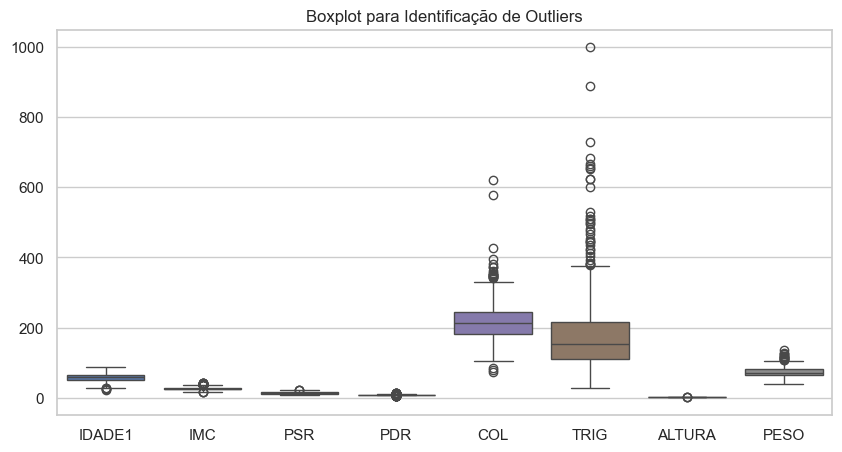

In [28]:
# Visualização de Outliers (Boxplot)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df)
plt.title("Boxplot para Identificação de Outliers")
plt.show()

# DECISÃO SOBRE OUTLIERS:
# Observação visual: Pontos muito fora dos "bigodes" (whiskers) são candidatos a outliers.
# Se desejar remover, descomente as linhas abaixo (exemplo removendo quem está > 3 desvios):
#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [29]:
# Seleção: Ficamos com o IMC e removemos Peso/Altura para evitar redundância.
# Assim o algoritmo não dá peso triplo ao tamanho da pessoa.
cols_to_use = ['IDADE1', 'IMC', 'PSR', 'PDR', 'COL' ,'TRIG','ALTURA', 'PESO']
df_model = df[cols_to_use].copy()

# Transformação Logarítmica: "Amassa" os valores muito altos de Colesterol e Triglicérides
# Isso impede que eles dominem a distância sozinhos.
cols_log = ['TRIG', 'COL']
df_model[cols_log] = np.log1p(df_model[cols_log])




# Escalonamento Robusto: Usa a mediana em vez da média. 
# Se sobrar algum outlier, ele não estraga a escala dos outros dados.
scaler = RobustScaler()
df_scaled_array = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(df_scaled_array, columns=df_model.columns)

print("Dados transformados e prontos (Primeiras 5 linhas):")
display(df_scaled.head())

Dados transformados e prontos (Primeiras 5 linhas):


,IDADE1,IMC,PSR,PDR,COL,TRIG,ALTURA,PESO
0,-0.266667,2.297113,0.50,1.0,-0.208689,0.154185,-1.083333,0.941176
1,-0.400000,0.275066,-0.75,0.0,0.166165,0.119323,-0.333333,0.058824
2,0.333333,0.000000,0.00,1.0,0.642178,-0.756818,-0.583333,-0.294118
3,0.333333,0.142782,-0.25,0.0,-0.532974,-0.494685,1.083333,0.882353
4,-0.466667,-0.594226,0.00,1.0,0.405066,1.002847,-0.333333,-0.588235


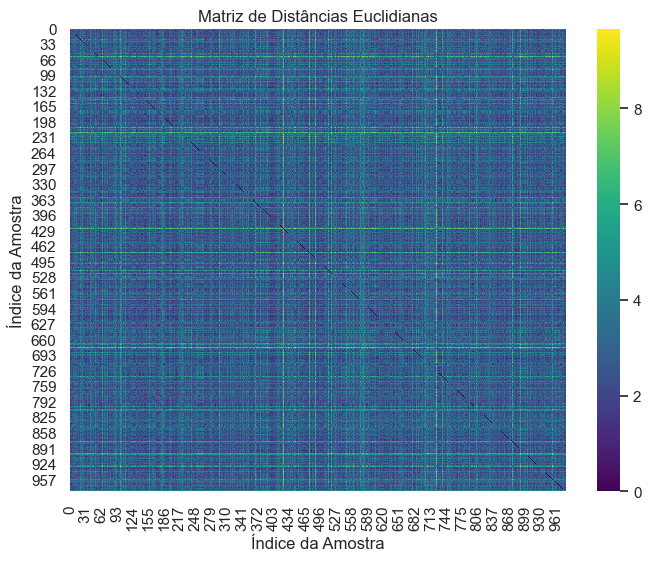

In [30]:
# Calcula a distância euclidiana entre todos os pares de observações
distancias = pdist(df_scaled, metric='euclidean')
matriz_distancias = squareform(distancias)

# Visualização da Matriz de Distâncias (Heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_distancias, cmap='viridis')
plt.title("Matriz de Distâncias Euclidianas")
plt.xlabel("Índice da Amostra")
plt.ylabel("Índice da Amostra")
plt.show()

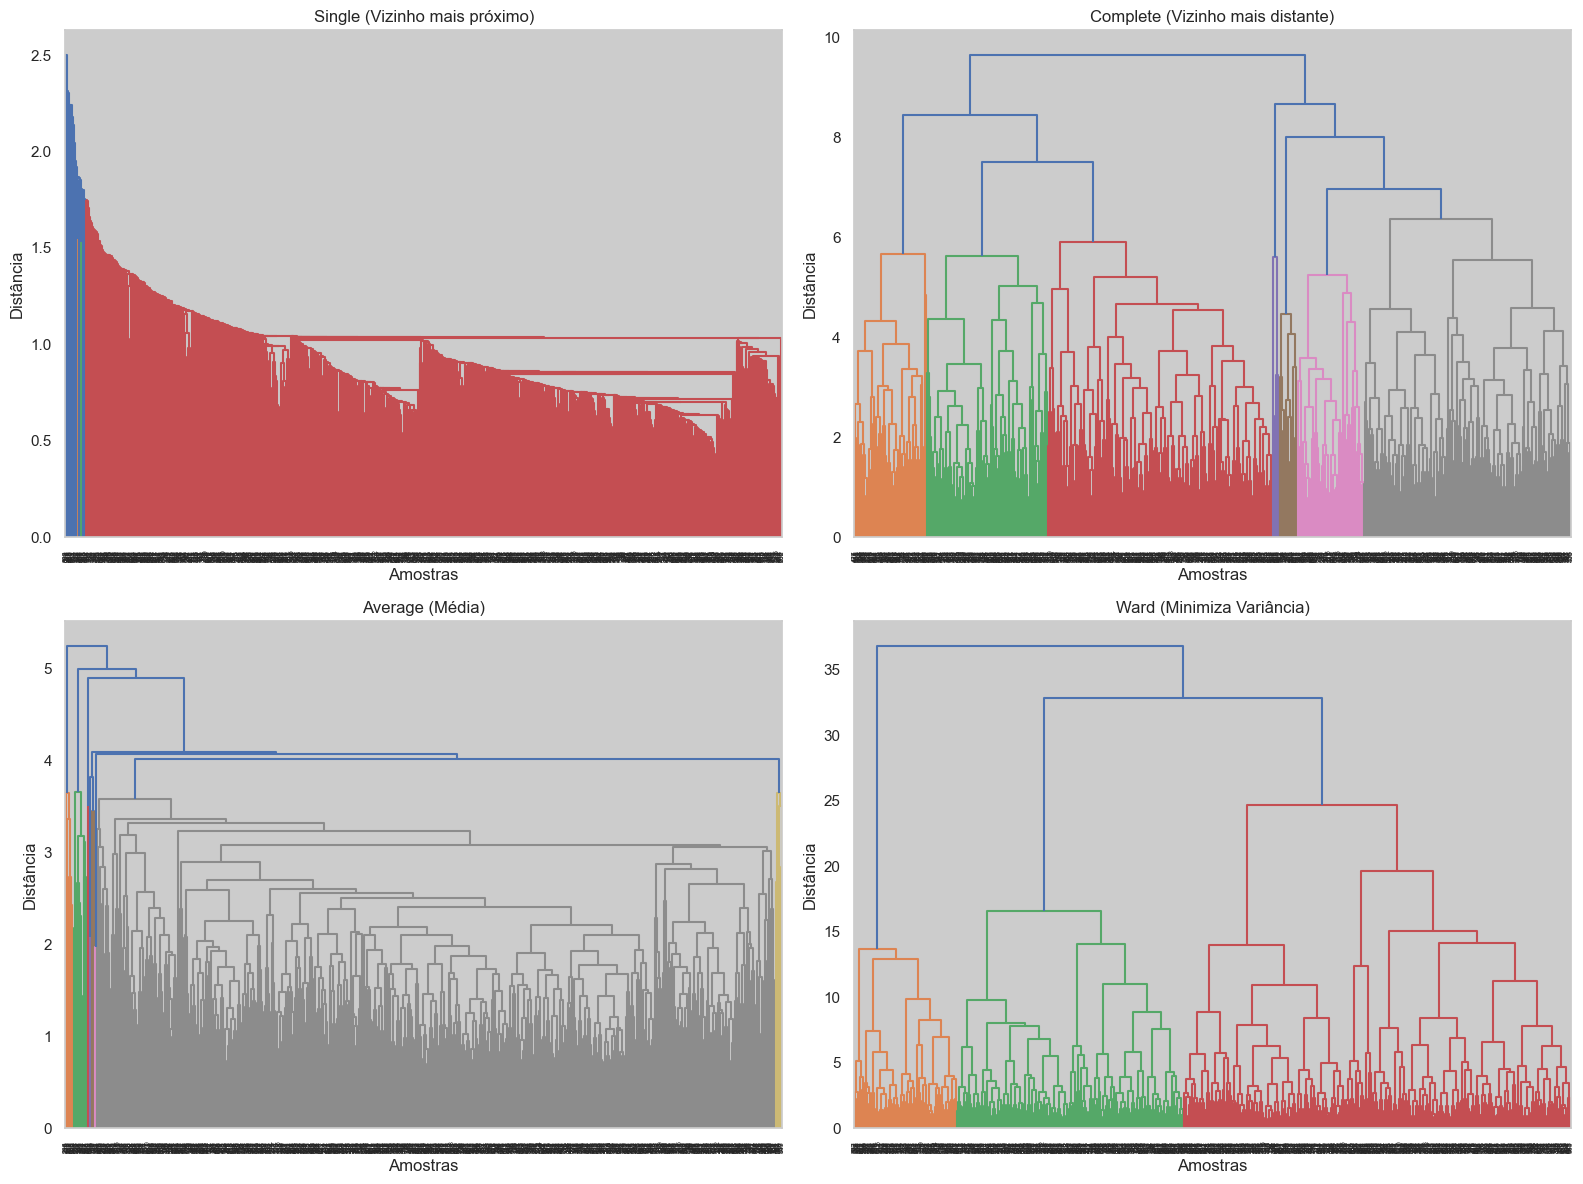

In [31]:
# Configuração da figura 2x2
# Ajustei o tamanho (figsize) para ficar mais quadrado/proporcional para 2 linhas
fig, axes = plt.subplots(2, 2, figsize=(16, 12)) 

metodos = ['single', 'complete', 'average', 'ward']
titulos = ['Single (Vizinho mais próximo)', 
           'Complete (Vizinho mais distante)', 
           'Average (Média)',
           'Ward (Minimiza Variância)']

Z_list = {}

# "Achatamos" a matriz de eixos (que era 2x2) para uma lista simples de 4 itens
# Assim podemos iterar de 0 a 3 sem nos preocuparmos com linhas e colunas
axes_flat = axes.flatten() 

for i, metodo_atual in enumerate(metodos):
    # Selecionamos o gráfico correspondente na lista achatada
    ax = axes_flat[i]
    
    # Calcular o linkage
    # Nota: Ward exige distancia euclidiana
    Z = linkage(df_scaled, method=metodo_atual, metric='euclidean')
    Z_list[metodo_atual] = Z
    
    # Plotar dendrograma no eixo selecionado (ax)
    dendrogram(Z, ax=ax)
    
    ax.set_title(titulos[i])
    ax.set_xlabel("Amostras")
    ax.set_ylabel("Distância")

plt.tight_layout()
plt.show()

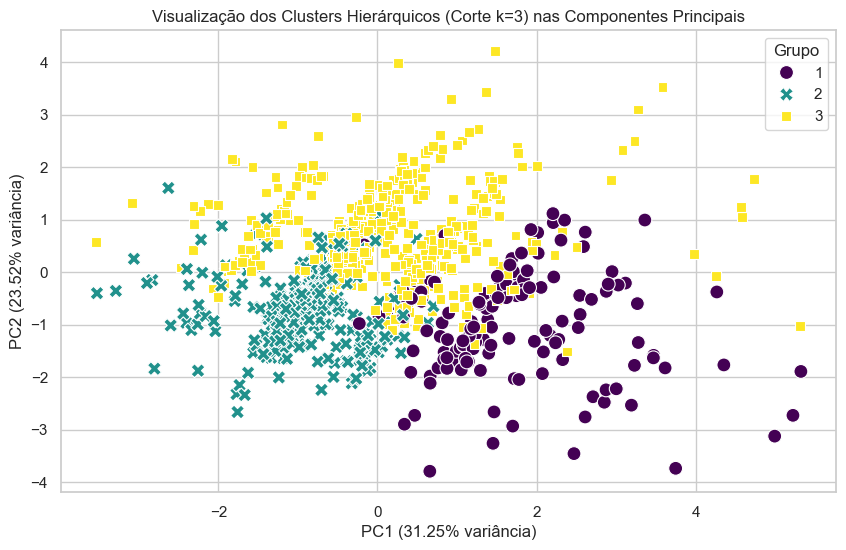

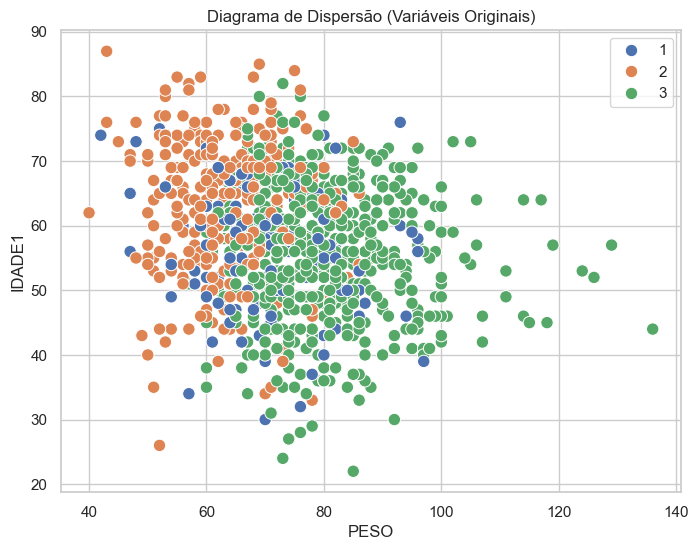

In [32]:
# Escolhendo um método para cortar (ex: Average) e definindo número de clusters (k)
# Você pode definir o corte por altura (distance_threshold) ou por número de clusters (n_clusters)
metodo_escolhido = 'ward'
k_hierarquico = 3  # Defina quantos grupos você "viu" no dendrograma

# Obtendo os labels dos grupos
labels_hierarquico = fcluster(Z_list[metodo_escolhido], t=k_hierarquico, criterion='maxclust')

# Redução de dimensionalidade com PCA para visualização 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster_Hierarquico'] = labels_hierarquico

# Plotando os scores das primeiras componentes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Hierarquico', data=df_pca, 
                palette='viridis', s=100, style='Cluster_Hierarquico')
plt.title(f"Visualização dos Clusters Hierárquicos (Corte k={k_hierarquico}) nas Componentes Principais")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variância)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variância)")
plt.legend(title='Grupo')
plt.show()

# Diagrama de Dispersão "Deinter" (Exemplo genérico de Variável x Variável)
# Substitua 'Var1' e 'Var2' pelas variáveis específicas que você quer analisar
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PESO', y='IDADE1', hue=labels_hierarquico, palette='deep', data=df, s=80)
plt.title("Diagrama de Dispersão (Variáveis Originais)")
plt.show()

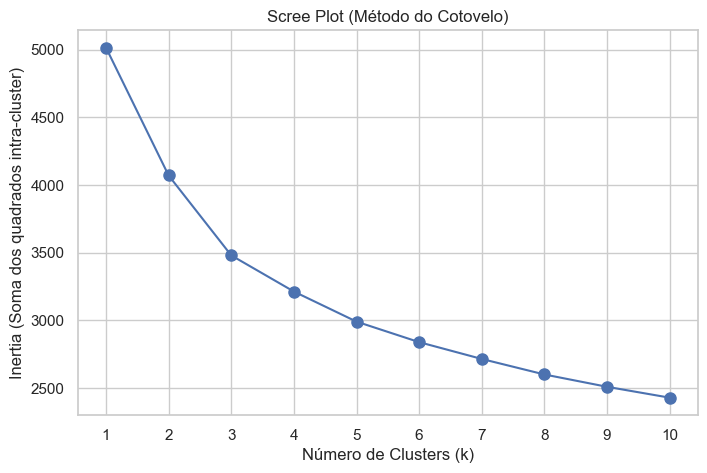

In [33]:
inertia = []
range_k = range(1, 11) # Testando de 1 a 10 grupos

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plot do Cotovelo (Scree Plot)
plt.figure(figsize=(8, 5))
plt.plot(range_k, inertia, 'bo-', markersize=8)
plt.title('Scree Plot (Método do Cotovelo)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia (Soma dos quadrados intra-cluster)')
plt.xticks(range_k)
plt.grid(True)
plt.show()

In [34]:
# Baseado no gráfico acima, escolha o melhor k (onde a curva dobra)
k_final = 3

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
kmeans_final.fit(df_scaled)
labels_kmeans = kmeans_final.labels_

# Mostrando os Centróides (Centros de Gravidade)
# Precisamos despadronizar para entender os valores reais
centroides_scaled = kmeans_final.cluster_centers_
centroides_reais = scaler.inverse_transform(centroides_scaled)

df_centroides = pd.DataFrame(centroides_reais, columns=df.columns)
df_centroides.index.name = "Cluster"
print(f"\nCentróides dos Grupos (K-Means k={k_final}) - Escala Original:")
display(df_centroides)


Centróides dos Grupos (K-Means k=3) - Escala Original:


,IDADE1,IMC,PSR,PDR,COL,TRIG,ALTURA,PESO
Cluster,,,,,,,,
0,54.179688,28.855625,13.500000,8.236979,5.407246,5.210120,1.703854,83.515625
1,62.138568,24.369446,13.533487,7.979215,5.303421,4.876980,1.627229,64.445727
2,57.079755,27.202822,16.803681,10.466258,5.408243,5.135659,1.650491,74.245399


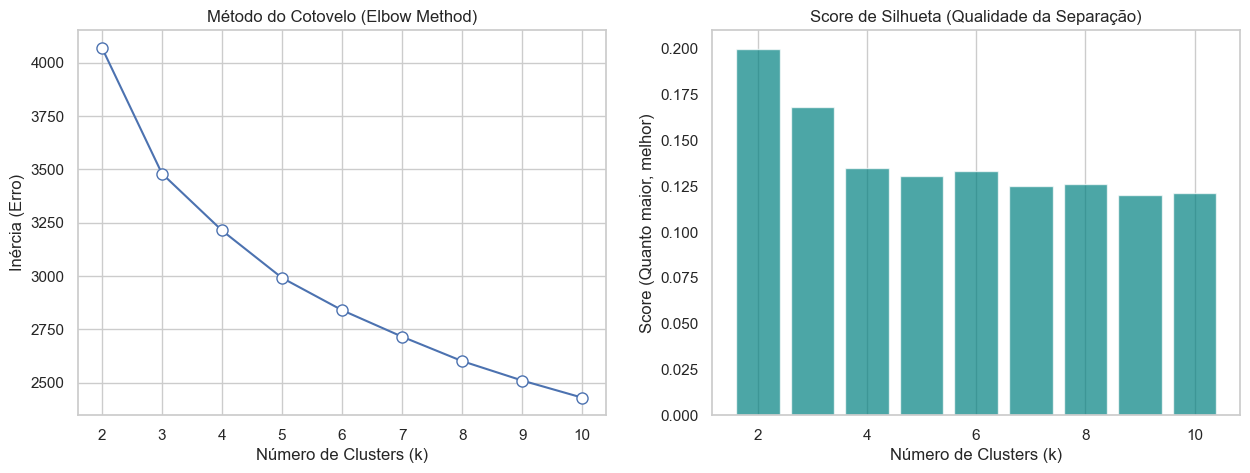

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Intervalo de K para testar (de 2 a 10 grupos)
range_k = range(2, 11)
inertias = []
silhouettes = []

for k in range_k:
    # Rodamos o KMeans
    kmeans_teste = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_teste = kmeans_teste.fit_predict(df_scaled)
    
    # Guardamos as métricas
    inertias.append(kmeans_teste.inertia_) # Para o Cotovelo (menor é melhor, mas deve ter "quebra")
    silhouettes.append(silhouette_score(df_scaled, labels_teste)) # Para Silhueta (maior é melhor)

# Plotando os gráficos lado a lado
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico do Cotovelo
ax[0].plot(range_k, inertias, 'bo-', markerfacecolor='w', markersize=8)
ax[0].set_title('Método do Cotovelo (Elbow Method)')
ax[0].set_xlabel('Número de Clusters (k)')
ax[0].set_ylabel('Inércia (Erro)')
ax[0].grid(True)

# Gráfico da Silhueta
ax[1].bar(range_k, silhouettes, color='teal', alpha=0.7)
ax[1].set_title('Score de Silhueta (Qualidade da Separação)')
ax[1].set_xlabel('Número de Clusters (k)')
ax[1].set_ylabel('Score (Quanto maior, melhor)')
ax[1].grid(axis='y')

plt.show()

In [36]:
# --- DEFINA SEU K AQUI ---
k_final = 3 # Ajuste conforme o gráfico anterior (ex: 3 ou 4)
# -------------------------

# 1. Rodar o modelo
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_final = df.copy() # Cópia do original para guardar os resultados
df_final['Cluster_KMeans'] = kmeans.fit_predict(df_scaled)

# 2. Calcular os Centróides (Perfil Médio de cada grupo)
centroides_scaled = kmeans.cluster_centers_

# 3. Reverter o Escalonamento (RobustScaler -> Escala com Log)
centroides_log = scaler.inverse_transform(centroides_scaled)
df_centroides = pd.DataFrame(centroides_log, columns=df_scaled.columns)

# 4. Reverter o Logaritmo (Log -> Valor Original Real)
# Apenas nas colunas que aplicamos log: 'TRIG' e 'COL'
cols_log = ['TRIG', 'COL'] # Mesmas colunas do início
df_centroides[cols_log] = np.expm1(df_centroides[cols_log]) # expm1 é o inverso de log1p

# Ajustes finais para exibição
df_centroides.index.name = "Cluster"
df_centroides = df_centroides.round(1)

print(f"--- PERFIL MÉDIO DOS {k_final} GRUPOS (Valores Reais) ---")
display(df_centroides)

# Contagem de pacientes
print("\nQuantidade de pacientes por grupo:")
print(df_final['Cluster_KMeans'].value_counts().sort_index())

--- PERFIL MÉDIO DOS 3 GRUPOS (Valores Reais) ---


,IDADE1,IMC,PSR,PDR,COL,TRIG,ALTURA,PESO
Cluster,,,,,,,,
0,54.2,28.9,13.5,8.2,222.0,182.1,1.7,83.5
1,62.1,24.4,13.5,8.0,200.0,130.2,1.6,64.4
2,57.1,27.2,16.8,10.5,222.2,169.0,1.7,74.2



Quantidade de pacientes por grupo:
Cluster_KMeans
0    385
1    432
2    163
Name: count, dtype: int64


C:\Users\Usuario\AppData\Local\Temp\ipykernel_17216\3721017334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_KMeans', y=var, data=df_final, ax=axes[i], palette='viridis')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17216\3721017334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_KMeans', y=var, data=df_final, ax=axes[i], palette='viridis')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17216\3721017334.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_KMeans', y=var, data=df_final, ax=axes[i], pa

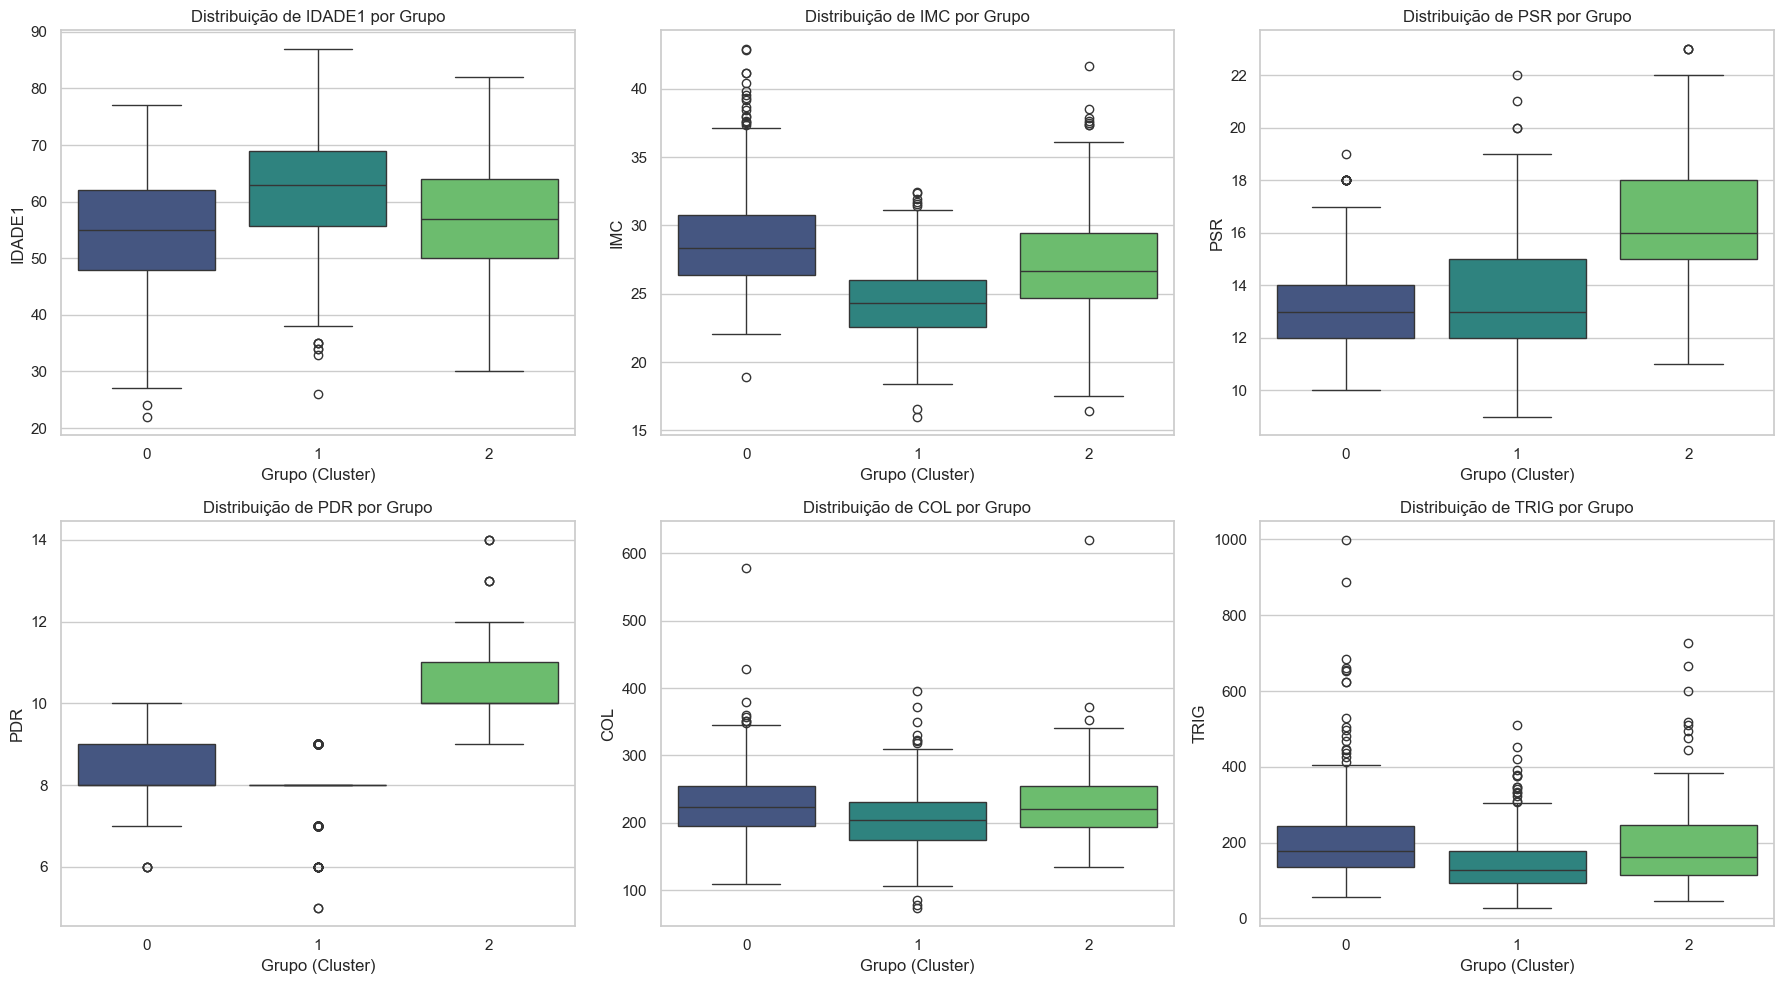

In [37]:
# Selecionamos as variáveis para plotar
vars_plot = ['IDADE1', 'IMC', 'PSR', 'PDR', 'COL', 'TRIG']

# Configuração do painel de gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(vars_plot):
    sns.boxplot(x='Cluster_KMeans', y=var, data=df_final, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribuição de {var} por Grupo')
    axes[i].set_xlabel('Grupo (Cluster)')

plt.tight_layout()
plt.show()